# Parallel Experimentation with BERT on AzureML

[SentEval](https://github.com/facebookresearch/SentEval) is a widely used benchmarking tool for evaluating general-purpose sentence embeddings. It provides a simple interface for evaluating embeddings on up to 17 supported downstream tasks (such as sentiment classification, natural language inference, semantic similarity, etc.) 

Due to the fact that different BERT layers capture different information, and that the choice of pooling layer and pooling strategy for the encoding is highly dependent on the final finetuning task, we use SentEval to evaluate different combinations of these encoding parameters on the STSBenchmark dataset. In this notebook, we aim to show an example of
* running SentEval experiments with BERT encodings
* running parallel jobs on AzureML compute targets for faster experimentation (extracting sequence encodings from BERT with 110M parameters is computationally expensive, even without finetuning. Each experiment could take an hour or more, depending on the specs of the machine, so running multiple experiments sequentially can quickly add up) 

### 00 Global Settings

In [1]:
import os
import sys
import pickle
import shutil
import itertools
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from azureml.core import Experiment
from azureml.data.data_reference import DataReference
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails

sys.path.append("../../")
from utils_nlp.azureml.azureml_utils import get_or_create_workspace, get_or_create_amlcompute
from utils_nlp.models.bert.common import Language, Tokenizer
from utils_nlp.models.bert.sequence_encoding import BERTSentenceEncoder, PoolingStrategy
from utils_nlp.eval.senteval import SentEvalConfig

In [2]:
CACHE_DIR = "./temp"
LOCAL_SENTEVAL_DIR = os.path.join(CACHE_DIR, "SentEval")

MODEL_PARAMS = {
    "num_gpus": 1,
    "language": Language.ENGLISH,
    "to_lower": True,
    "max_len": 128,
    "cache_dir": CACHE_DIR
}

SENTEVAL_PARAMS = {
    "usepytorch": True, 
    "batch_size": 128,
    "transfer_tasks": ["STSBenchmark"]
}

EXP_PARAMS = {
    "layer_index": range(12),
    "pooling_strategy": [PoolingStrategy.MEAN, PoolingStrategy.MAX],
}

# azureml config
subscription_id = "YOUR_SUBSCRIPTION_ID"
resource_group = "YOUR_RESOURCE_GROUP_NAME"  
workspace_name = "YOUR_WORKSPACE_NAME"  
workspace_region = "YOUR_WORKSPACE_REGION"

CONFIG_PATH = ".azureml"
EXPERIMENT_NAME = "NLP-SS-bert"
CLUSTER_NAME = "eval-gpu"
MAX_NODES = None

In [ ]:
os.makedirs(CACHE_DIR, exist_ok=True)

### 01 Set up AzureML resources

We set up the following AzureML resources for this example:
* A [Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), a centralized hub for all the artifacts you create when you use Azure Machine Learning service
* An [Experiment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment.experiment?view=azure-ml-py), which acts a container for trials or model runs
* A [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-access-data), a compute location-independent abstraction of data in Azure storage accounts

In [3]:
ws = get_or_create_workspace(
    config_path=CONFIG_PATH,
    subscription_id=subscription_id,
    resource_group=resource_group,
    workspace_name=workspace_name,
    workspace_region=workspace_region,
)
exp = Experiment(workspace=ws, name=EXPERIMENT_NAME)
ds = ws.get_default_datastore()

### 02 Set up SentEval

Clone the repository.

In [4]:
if not os.path.exists(LOCAL_SENTEVAL_DIR):
    !git clone https://github.com/facebookresearch/SentEval.git $LOCAL_SENTEVAL_DIR

Run the bash script to download the data for auxiliary transfer tasks.

In [5]:
data_path = os.path.join(LOCAL_SENTEVAL_DIR, "data/downstream")
data_script = "get_transfer_data.bash"
cwd = os.path.abspath(os.getcwd())

if not any([f.is_dir() for f in os.scandir(data_path)]):
    !cd $data_path && ./$data_script

Upload the SentEval dependency to datastore.

In [6]:
ds.upload(
    src_dir=LOCAL_SENTEVAL_DIR,
    target_path=os.path.join(EXPERIMENT_NAME, "senteval"),
    overwrite=False,
    show_progress=False,
)

$AZUREML_DATAREFERENCE_29393ed34c4d4ab398be34e5f5952c2c

### 03 Define experiment configurations
We define a set of static configurations, which entails model parameters that will stay consistent across all experiments, in `SentEvalConfig`. We also define the parameter space that will vary across the experiments. We serialize the configuration objects and upload them to our datastore to make them accessible to all experiments.

In [7]:
sc = SentEvalConfig(
    model_params=MODEL_PARAMS,
    senteval_params=SENTEVAL_PARAMS,
)

In [8]:
parameter_groups = list(itertools.product(*list(EXP_PARAMS.values())))

In [9]:
os.makedirs(os.path.join(CACHE_DIR, "config"), exist_ok=True)

static_config = (
    SentEvalConfig(model_params=MODEL_PARAMS, senteval_params=SENTEVAL_PARAMS),
    os.path.join(CACHE_DIR, "config", "static_config.pkl"),
)
exp_configs = [
    (
        dict(zip(EXP_PARAMS.keys(), p)),
        os.path.join(CACHE_DIR, "config", "exp_config_{0:03d}.pkl".format(i)),
    )
    for i, p in enumerate(parameter_groups)
]

configs = [static_config] + exp_configs
for config in configs:
    pickle.dump(config[0], open(config[1], "wb"))

ds.upload_files(
    [c[1] for c in configs],
    target_path="{}/config".format(EXPERIMENT_NAME),
    overwrite=True,
    show_progress=False,
)

$AZUREML_DATAREFERENCE_07723c6c94b7431b9f811c8be538d8b7

### 04 Scale the compute target

Scale the number of nodes in the compute target to the number of experiments we want to run.

In [10]:
compute_target = get_or_create_amlcompute(
    workspace=ws,
    compute_name=CLUSTER_NAME,
    vm_size="STANDARD_NC6",
    min_nodes=len(parameter_groups),
    max_nodes=MAX_NODES,
    idle_seconds_before_scaledown=300,
    verbose=False,
)

print(
    "Scaling compute target {0} to {1} node(s)".format(
        CLUSTER_NAME, min(len(parameter_groups), int(MAX_NODES or 100))
    )
)

Scaling compute target eval-gpu to 24 node(s)


### 05 Define the execution script

Here we define the script to be executed for each experiment on the remote compute target. We deserialize the configuration objects from the datastore to specify the model parameters for the experiment, and run the SentEval evaluation engine with that model for the STSBenchmark transfer task.

As specified in the SentEval repo, we implement the **batcher** function, which transforms a batch of text sentence into sentence embeddings.

After running SentEval, we serialize the output.

In [11]:
src_dir = os.path.join(CACHE_DIR, EXPERIMENT_NAME)
os.makedirs(src_dir, exist_ok=True)
if not os.path.exists(os.path.join(src_dir, "utils_nlp")):
    shutil.copytree("../../utils_nlp", os.path.join(src_dir, "utils_nlp"))

In [12]:
%%writefile $src_dir/run.py
import pickle
import argparse
import os
from utils_nlp.eval.senteval import SentEvalConfig
from utils_nlp.models.bert.sequence_encoding import BERTSentenceEncoder


def prepare_output(output_dir, config_file):
    os.makedirs(output_dir, exist_ok=True)
    out = os.path.join(
        output_dir,
        "results_{}.pkl".format(config_file.split("/")[-1].split(".")[0][-3:]),
    )
    return out


def batcher(params, batch):
    sentences = [" ".join(s).lower() for s in batch]
    embeddings = params["model"].encode(
        sentences, batch_size=params["batch_size"], as_numpy=True
    )
    return embeddings


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, dest="data_dir")
    parser.add_argument(
        "--static_config",
        type=str,
        dest="static_config",
        help="Filename of serialized static config object",
    )
    parser.add_argument(
        "--exp_config",
        type=str,
        dest="exp_config",
        help="Filename of serialized experiment config object",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        dest="output_dir",
        help="Directory to write serialized results to",
    )
    args = parser.parse_args()

    # Import senteval
    sys.path.insert(0, args.data_dir)
    import senteval

    # Deserialize configs
    static_config = pickle.load(open(args.static_config, "rb"))
    exp_config = pickle.load(open(args.exp_config, "rb"))

    # Update senteval params for this experiment
    params = static_config.senteval_params
    params["model"] = BERTSentenceEncoder(**static_config.model_params)
    for k, v in exp_config.items():
        setattr(params["model"], k, v)
    params["task_path"] = "{}/data".format(args.data_dir)

    # Run the senteval engine
    se = senteval.engine.SE(params, batcher)
    results = se.eval(params["transfer_tasks"])

    # Pickle the output
    output_file = prepare_output(args.output_dir, args.exp_config)
    print("Pickling to {}".format(output_file))
    pickle.dump(results, open(output_file, "wb"))

Writing ./temp/NLP-SS-bert/run.py


### 06 Run the experiments in parallel

We iterate through the experiment parameter combinations and submit each job to AmlCompute as a `PyTorch` estimator. Since we explicitly set `node_count=1` and `process_count_per_node=1` in the estimator, the jobs will run in parallel.

In [13]:
runs = []
for i in range(len(parameter_groups)):
    est = PyTorch(
        source_directory=src_dir,
        script_params={
            "--data_dir": ds.path("{}/senteval".format(EXPERIMENT_NAME)).as_mount(),
            "--static_config": ds.path(
                "{0}/{1}/{2}".format(
                    EXPERIMENT_NAME, "config", static_config[1].split("/")[-1]
                )
            ).as_mount(),
            "--exp_config": ds.path(
                "{0}/{1}/{2}".format(
                    EXPERIMENT_NAME, "config", exp_configs[i][1].split("/")[-1]
                )
            ),
            "--output_dir": "./outputs",
        },
        compute_target=compute_target,
        entry_script="run.py",
        inputs=[
            DataReference(
                datastore=ds, path_on_datastore="outputs"
            ).as_upload(
                path_on_compute=os.path.join("./outputs/results_{0:03d}.pkl".format(i))
            )
        ],
        node_count=1,
        process_count_per_node=1,
        use_gpu=True,
        framework_version="1.1",
        conda_packages=["numpy", "pandas"],
        pip_packages=[
            "scikit-learn==0.20.3",
            "azureml-sdk==1.0.53",
            "pytorch-pretrained-bert>=0.6",
        ],
    )

    run = exp.submit(est)
    runs.append(run)

Each run object is collected in `runs`, so we can monitor any run via a Jupyter widget for debugging.

In [14]:
#RunDetails(runs[0]).show()

Alternatively, block until the runs are complete.

In [15]:
_ = runs[-1].wait_for_completion()

Finally, we pull down the serialized outputs of each experiment from the datastore and inspect the metrics for analysis.

In [19]:
ds.download(
    target_path=CACHE_DIR,
    prefix="outputs",
    show_progress=False,
)

24

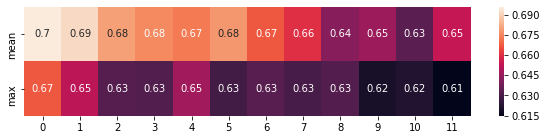

In [30]:
%matplotlib inline

results = [
    pickle.load(open(f, "rb"))
    for f in sorted(glob.glob(os.path.join(CACHE_DIR, "outputs", "*.pkl")))
]

df = pd.DataFrame(
    np.reshape(
        [r["STSBenchmark"]["pearson"] for r in results],
        (len(EXP_PARAMS["layer_index"]), len(EXP_PARAMS["pooling_strategy"])),
    ).T,
    index=[s.value for s in EXP_PARAMS["pooling_strategy"]],
    columns=EXP_PARAMS["layer_index"],
)
fig, ax = plt.subplots(figsize=(10,2)) 
sns.heatmap(df, annot=True, fmt=".2g", ax=ax)